# NLP(自然言語処理)
## 1.
まず使用するライブラリやメソッドを読み込む  
グローバル変数を宣言

In [65]:
# 更新したライブラリのオートリロード
%load_ext autoreload
%autoreload 2
import gc
import numpy as np
import pandas as pd
from itertools import chain
from tqdm import tqdm
import datetime
import re
import glob
import sys
import pickle
import os
from gensim import corpora, matutils
HOME = os.path.expanduser('~')

# Original Library
sys.path.append(f'{HOME}/kaggle/data_analysis/library/')
import utils
from pararell_utils import pararell_process

# NLP Library
from nlp_utils import stems, corpus_word_id, words
from wordnet import search_similar_words

logger = utils.logger_func()
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)


#========================================================================
# Global Variables
#========================================================================
key = 'unique_id' # NLPの処理を行うデータセットにおいてユニークな情報（IDなど）をもつカラム名
target = 'target' # テキスト分類を行う際の目的変数情報が入ったカラム名
ignore_list = [key, target] # テキスト分類を行う際のデータセットには入れるが、説明変数として使用しないカラムリスト
regex_abcABC123 = re.compile(u"[0-9０-９a-zA-Z]") # 形態素解析を行う際、除外したい単語を抽出する正規表現コンパイラ
morph_list = ['名詞', '形容詞', '動詞', '感動詞'] # 形態素解析を行う際、単語として残したい品詞リスト
#  morph_list = ['名詞']

IndentationError: unexpected indent (<ipython-input-65-9e88a2b80929>, line 40)

## 2.
### データセットロード
使用するデータセットを読み込み、行列数と内容の一部を出力.

In [66]:
# =========================================
# Args
# =========================================
year = 2015
train_path2015 = '../input/jr_train2015.xls' # 2015のデータセット
train_path2016 = '../input/jr_train2016.xls' # 2016のデータセット
test_path2017 = '../input/jr_test2017.xls' # 2017のデータセット

# =========================================
# Data Load
# =========================================
train_2015 = pd.read_excel(train_path2015)[['unique_id', 'contents', 'date', 'target']].dropna()
train_2016 = pd.read_excel(train_path2016)[['unique_id', 'contents', 'date', 'target']].dropna()
raw_train = pd.concat([train_2015, train_2016], axis=0)
raw_test = pd.read_excel(test_path2017)[['unique_id', 'contents', 'date', 'target']].dropna()
raw_train[key] = np.arange(len(raw_train))
raw_test[key] = np.arange(len(raw_test))
raw_train.reset_index(drop=True, inplace=True)

del train_2015, train_2016
gc.collect()

print(raw_train.shape)
display(raw_train.head())
print(raw_test.shape)
display(raw_test.head())

(2226, 4)


,unique_id,contents,date,target
0,0,京都16時発 新快速敦賀行き。\n山科ー大津間のトンネル内で異常な揺れを感じました。\n小刻...,2015-04-01,騒音・振動・衝撃
1,1,本日3/31に住吉駅より8:12発の快速(５７２４T)に乗車したのですが、発車時の加速がきつ...,2015-04-02,騒音・振動・衝撃
2,2,3月19日に自宅が吹田総合車両所の近くに住んでいて特急の城崎温泉行きの列車が毎日23時と朝の...,2015-04-02,騒音・振動・衝撃
3,3,車内アナウンスの音声が非常に耳障り。単にボリュームだけの問題ではなく、マイクの使い方、機器に...,2015-04-02,放送（過剰）
4,4,平成27年4月1日の2077Ｍの車内（号車・座席箇所は不明）で、お客様よりいつも287系を利...,2015-04-03,騒音・振動・衝撃


(1363, 4)


,unique_id,contents,date,target
0,0,17時に大阪発の米原方面新快速を利用しました。3月も終わりかけで暖かくもなってきましたが、今...,2017-04-03,暖房（不足）
1,1,毎日通勤で早朝、夜にびわ湖線を利用してます。車内の清掃は、おそらく終電後車庫に戻ってからメン...,2017-04-03,汚損（車内外）
2,2,先日車両の異音について質問させていただきましたところ、早速にご回答を頂き有難うございました。...,2017-04-03,騒音・振動・衝撃
3,3,今朝、電車に乗ろうとした際に前の人が後ろを確認せずドアを閉めた為、身体が挟まれました。\n正...,2017-04-03,機能要望
4,4,明石駅7：10発 新快速\n車両は真ん中になります。\nあと休みの日ですと、明石駅15：06...,2017-04-03,汚損（車内外）



#### 【参考】形態素解析テスト
データが少ない場合、表記ゆれを許すとユニークな表現ばかりになってしまい、パターンの特定が難しくなる。
その対策としては、語幹に変換するというのが一般的な手法である。
ただ、語幹にすることで失われる情報もあるので、両方を取得してストップワードやキーワード抽出で選り分けるのが望ましいが、工数は倍になる。
ルールベースの対策としては、特定のワードのみパターン抽出するという手法もある。

In [67]:
# 下記のパターンの場合、「してほしい」という単語は要望の意をほしいでくみ取れるが、語幹にすることで「して」の意を失っている
# 形態素解析を行う際、単語として残したい品詞リスト
morph_list = ['名詞', '形容詞', '動詞', '記号']
# テキスト例
text = '外国人の刊行'
for morph in morph_list:
    args={'text':text, 'morph':morph, 'regex':True}
    tmp_test = stems(**args)
    print(tmp_test)
sys.exit()

['外国人', '刊行']
[]
[]
[]


SystemExit: 

## 3.
### 形態素解析
**unique_id別にテキストを形態素解析にかけ、指定した品詞の単語リストを作成する**  
ここで作成するtrain_word_dictは後々作成する学習用データセットの元になる.  
文書量が多いと時間を要する（1,000テキストで90秒くらい）ので、完了後にpickle形式で保存しておく

In [69]:
# =========================================
# Args
# =========================================
year = 2015
output_train = f'../input/train_word_split_{year}_2016' # 学習用データセットの形態素解析結果を保存するファイル名
output_test = f'../input/test_word_split_2017' # テスト用データセットの形態素解析結果を保存するファイル名
col_text = 'contents' # データセットでテキストデータをもつカラム名

# 個別
org_dict = {
    'きこえない' : '聞こえない',
    'きこえなかった' : '聞こえない',
    'きこえず' : '聞こえない',
    'きこえません' : '聞こえない',
    'きき取れない' : '聞こえない',
    'ききとれない' : '聞こえない',
    'ききとる' : '聞こえない',
    'きき取る' : '聞こえない',
    '聞こえない' : '聞こえない',
    '聞こえなかった' : '聞こえない',
    '聞こえず' : '聞こえない',
    '聞こえません' : '聞こえない',
    '聞き取れない' : '聞こえない',
    '聞きとれない' : '聞こえない',
    'できません' : 'できない',
    'できなかった' : 'できない',
    '出来ません' : 'できない',
    '出来なかった' : 'できない',
    'なかった' : 'ない',
    '無かった' : 'ない',
    '①' : '①',
    '②' : '②',
    '外国' : '外国',
    '外国人' : '外国人'
}


# 形態素解析を並列処理に回すラッパー関数(引数が複数ある場合, ラッパーが必要なだけ)
def get_pararell_stems(args):
    '''stemsメソッド内では形態素解析を行い、分かち書きした単語リストを返している'''
    return args[0], stems(**args[1])


def get_stems(df):
    '''
    Explain:
        並列処理でMeCabに入力し、各テキストを分かち書きする
    Args:
        df(DataFrame): unique_idとテキストを格納したpandas DataFrame.
    Return:
        id_word_dict(dict): unique_id別に分かち書きした単語リストを格納したdictionary
    '''
    #========================================================================
    # dictにunique_id別の単語リストが格納される
    #========================================================================
    id_word_dict = {} # 分かち書きの結果を格納する辞書
    id_list = df[key].values
    doc_list = df[col_text].values
    
    # pararell
    arg_list = []
    org_word_dict = {}
    for morph in tqdm(morph_list):
        for uid, doc in zip(id_list, doc_list):
            
            # ============================================================
            # テキストから個別抽出したい単語を別途追加できるように辞書にいれとく
            if uid not in org_word_dict:
                for word in org_dict.keys():
                    if doc.count(word):
                        if uid in org_word_dict:
                            org_word_dict[uid] += [org_dict[word]]
                        else:
                            org_word_dict[uid] = [org_dict[word]]
            # ============================================================
                
            import mojimoji
            doc = mojimoji.zen_to_han(doc, kana=False)
            doc = doc.replace(u'\n', '').replace('：', '').replace('・', '').replace("'", '').replace('''"''', '').replace("`", '').replace(u'\u3000', '').replace('〓', '')
            arg_list.append([uid, {'text':doc, 'morph':morph, 'regex':True}])
        p_list = pararell_process(get_pararell_stems, arg_list)
        for p in p_list:
            if p[0] in id_word_dict:
                id_word_dict[p[0]] += p[1]
            else:
                id_word_dict[p[0]] = p[1]
                
    for k, v in org_word_dict.items():
        id_word_dict[k] += v
        
    return id_word_dict


# 形態素解析を並列処理に回すラッパー関数(引数が複数ある場合, ラッパーが必要なだけ)
def get_pararell_words(args):
    '''wordsメソッド内では形態素解析を行い、分かち書きした単語リストを返している'''
    return args[0], words(**args[1])


def get_words(df):
    '''
    Explain:
        並列処理でMeCabに入力し、各テキストを分かち書きする
    Args:
        df(DataFrame): unique_idとテキストを格納したpandas DataFrame.
    Return:
        id_word_dict(dict): unique_id別に分かち書きした単語リストを格納したdictionary
    '''
    #========================================================================
    # dictにunique_id別の単語リストが格納される
    #========================================================================
    id_word_dict = {} # 分かち書きの結果を格納する辞書
    id_list = df[key].values
    doc_list = df[col_text].values
    
    # pararell
    def pararell_parse(args):
        import MeCab
        tagger = MeCab.Tagger(f"-d /usr/lib/mecab/dic/mecab-ipadic-neologd")
        tagger.parse('')
        uid = args[0]
        doc = args[1]
        
        tmp_dict = {}
        job_list = []
        for token in tagger.parse(doc).split(u'\n'):
            token = token.split(u'\t')[0]
            if token!='EOS' and not(regex_abcABC123.match(token)) and len(token)!=0 :
                job_list.append(token)
                
        tmp_dict[uid] = job_list
        return tmp_dict
    
    arg_list = []
#     for uid, doc in zip(id_list, doc_list):
    p_list = Parallel(n_jobs=-1)([delayed(pararell_parse)(args) for args in zip(id_list, doc_list) ])
    
    [id_word_dict.update(p) for p in p_list]
        
    return id_word_dict

# sys.exit()
# 形態素解析の実行
train_stem_dict = get_stems(raw_train) # 学習データ
test_stem_dict = get_stems(raw_test) # テストデータ

# pickleで形態素解析後の単語リストを保存
utils.to_pkl_gzip(obj=train_stem_dict, path=output_train)
utils.to_pkl_gzip(obj=test_stem_dict, path=output_test)

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


#### 【参考】単語の出現頻度を可視化しTableauで確認するデータセットをCSV出力
このCSVファイルを見てキーワードを選別したり、Tableauによる可視化でテキスト別の単語の出現頻度などを把握

In [70]:
# Args
is_save=False # ここで出力したファイルを保存する場合
output_word_count = f'../output/{start_time[:11]}_jrw_train_word_count.csv'

# 前のセルで保存した分かち書き後のデータセットをロード
train_stem_dict = utils.read_pkl_gzip(path=output_train+'.gz')
test_stem_dict = utils.read_pkl_gzip(path=output_test+'.gz')

#========================================================================
# 各単語リストのUnique_id & Targetとの紐付きを保持する為、重複カウントはせず、
# 重複を残したままのデータセットにする(pandasで可視化するならgroupby, Tableauならrecord countすればいい)
#========================================================================
id_list = []
tmp_list = []
result = pd.DataFrame()
for ui, texts in train_stem_dict.items():
    tmp = pd.Series(texts, name='word').to_frame()
    tmp['unique_id'] = ui
    if len(result):
        result = pd.concat([result, tmp], axis=0)
    else:
        result = tmp.copy()
id_word = result.drop_duplicates()
df_cnt = result.merge(raw_train[[key, target]], on=key, how='inner')
if is_save:
    df_cnt.to_csv(output_word_count, index=False)

logger.info(f"\nComplete Get Words From Texts!!")
display(df_cnt.shape)
display(df_cnt.head(10))

2018-11-21 15:28:11,242 utils 28 [INFO]    [<module>] 
Complete Get Words From Texts!! 
2018-11-21 15:28:11,242 utils 28 [INFO]    [<module>] 
Complete Get Words From Texts!! 


(424935, 3)

,word,unique_id,target
0,京都,0,騒音・振動・衝撃
1,発,0,騒音・振動・衝撃
2,新快速,0,騒音・振動・衝撃
3,敦賀,0,騒音・振動・衝撃
4,行き,0,騒音・振動・衝撃
5,山科,0,騒音・振動・衝撃
6,ー大津間のトンネル内で異常な揺れを感じました。小刻みに大きめの縦揺れを感じた。問題なければい...,0,騒音・振動・衝撃
7,大津,0,騒音・振動・衝撃
8,間,0,騒音・振動・衝撃
9,トンネル内,0,騒音・振動・衝撃


#### 4. キーワードフィルターメソッドの読み込みとキーワードリストの取得
**前セルの単語リストなどを参考に別途作成したキーワードリスト(csv形式)を読み込む**  
**元データの単語リストをキーワードのみに絞る**  
**前の実行部分で出力済のid_word_dictを使用する**  

In [71]:
#========================================================================
# Args
#========================================================================
keyword_path = '../keyword/*.csv'

def get_keyword_list(keyword_path):
    '''
    Explain:
        読み込むキーワードリストは前提として
        delimiter: csv
        header: None
        col_1: keyword
        * col_1以外は読み込まない仕様
    Args:
        keyword_path(str): 読み込むキーワードリストのpath
    Return:
        keyword_list(list): リスト形式でキーワードリストを出力
    '''
    keyword_path = glob.glob(keyword_path)
    keyword_list = []
    for path in keyword_path:
        tmp = list(pd.read_csv(path, header=None).iloc[:, 0].values)
        keyword_list += tmp
    keyword_list = list(set(keyword_list))
    return keyword_list

def keyword_filter(id_word_dict, keyword_list):
    '''
    Explain:
        辞書のvalueに入った単語リストをキーワードのみに絞る
    Args:
        id_word_dict(dict): unique_idをkeyとし、単語リストをvalueとして格納したdict
        keyword_list(list): この後の特徴量セットに残すキーワードリスト.ここに含まれない単語は全て除外される
    Return:
        id_keyword_dict: 入力したid_word_dictから、キーワード以外を除外した単語リスト
    '''
    id_keyword_dict = {}
    for i, word_list in tqdm(id_word_dict.items()):
        new_id_keyword_dict = {}
        word_list = list(set(word_list) & set(keyword_list))
        id_keyword_dict[i] = word_list
    return id_keyword_dict

keyword_list = get_keyword_list(keyword_path)

# 元データの単語からキーワードのみ残す
train_keyword_dict = keyword_filter(train_stem_dict, keyword_list)
print(train_keyword_dict)

100%|██████████| 2226/2226 [00:00<00:00, 33573.38it/s]

{0: ['揺れ', '異常', '問題', 'いい', 'トンネル内'], 1: ['周り', 'きつい', '動作', '戴く', '加速', '吊り革', '修正', '調整'], 2: ['音', 'すごい', '近く', 'ほしい', 'オペレーター', '鳴る', '住む', '眠れる', '深夜'], 3: ['耳障り', '音声', '改善', 'アナウンス', '耳', '不愉快', 'なる', 'ない', '音質', '防止', 'マイク', 'ひどい', '非常', '車内', '問題', '大きい', '会社'], 4: ['うるさい', 'なる', '設備', '修理', 'テーブル', '原因', '鳴る', 'ガタガタ', '座席', '車内', '問題', '不明', '音', '整備'], 5: ['ほしい'], 6: ['臭い', 'ほしい', '頂く', '消臭剤', 'トイレ', '車内'], 7: ['ホーム', '汚物', 'いただく', 'できる'], 8: ['不便', '①', 'ない', 'ほしい', '設置', '座席', '減らす'], 9: ['近く', '①', '表示', 'ない', '台', 'ほしい', '踏切', '不備'], 10: ['アナウンス', 'なる', '表示', 'ない', '損ねる', '車内'], 11: ['臭い', '窓', 'なる', 'お願い', 'ない', '頂く', '換気', '吐く', '車内', '嘔吐'], 12: ['説明', 'なる', '停車', 'お願い', '車内'], 13: ['なる', 'ない', 'ほしい', '行先', '放送'], 14: ['ない', 'ほしい', '頂く', '要望', '車内'], 15: ['お願い', '修理', '事故', '欠陥', '音'], 16: ['治す'], 17: ['ない', '機能', 'なる'], 18: ['健康', '素晴らしい', '事故', '難しい', 'お願い', 'ない', '頂く', 'ホーム', '扉', '驚く', '減らす', '出来る', '慌てる', '大変', 'メンテナンス', '願う', '多い', '設計', 'なる', '老朽', 'できない', 'クロス

## 5.
### 類語取得メソッドの読み込みとキーワードリストの取得
* **各テキストの単語リストをループで流し、各単語の類語を取得する**  
* **類語の取得にはWordNet DBを使用**  
* **ここで取得した類語リストをチェックして、再度キーワードを絞り込む**  
* 類語が存在しなかった単語リストも合わせて出力しているが、これは表記ゆれや未知語の可能性が高いので要チェック  
**【参考】類語がどの様に取得できるかテストする**
-> wn_test=True

In [72]:
#========================================================================
# Args
#========================================================================
is_save = True
output_similar = f'../output/{start_time[:11]}_similar_word_list.csv' # 取得した類語リストを保存するパス
output_no_similar = f'../output/{start_time[:11]}_jrw_no_similar_word.csv' # 類語を取得できなかった単語リストを保存するパス

# WordNetがどんなものかテストする時はTrueにする
wn_test = True
wn_test = False
test_word = 'うるさい'

def get_similar_word(id_word_dict, keyword_list, original=False):
    '''
    Explain:
        単語リストを入力し、WordNet DBを使ってその類語を出力する.
    Args:
        id_word_dict(dict): key->unique_id(str), value->word_list(list)
        keyword_list(list): 
        original(bool)    : True  -> 入力した単語と類語の両方を出力
                            False -> 取得した類語リストのみを出力
    Return:
        sim_dict(dict)    : 取得した類語リストを格納した辞書. key -> unique_id, value -> similar_word_list
        no_wn_list(list)) : 類語を取得できなかった単語リスト
    '''
    sim_dict = {} # 戻り値となる類語辞書
    no_wn_list = [] # 戻り値となる類語のなかった単語リスト
    
    # 単語をループで格納していき, WordNetで類語を取得する
    for i, word_list in tqdm(id_word_dict.items()):
        tmp_list = []
        feature_keywords = []
    
        for word in word_list:
            # WordNet DB Test
            if wn_test:
                similar_words = search_similar_words(test_word, syn_num=3, smw_num=10, display=True)
                sys.exit()
            similar_words = search_similar_words(word, syn_num=3, smw_num=10, display=False)
    
            # 類語がない（DBに登録がない）単語も存在する
            if similar_words==0:
                no_wn_list.append(word)
                continue
            tmp_list.append(similar_words)
    
        # nestしてるlistを1次元にする
        feature_words = list( chain.from_iterable(tmp_list) )
        
        
        # original=Trueの場合、元の単語リストと類語リストを合わせてデータセットに格納する
        if original:
            feature_words = list(set(feature_words) & set(keyword_list)) + word_list
            
        # キーワードで表記ゆれや言葉の統一を図る為、置換を行う
        replace_dict = utils.read_pkl_gzip('../keyword/1120_jrw_replace_dict.gz')
        feature_words = [ replace_dict[word] if word in replace_dict else word for word in feature_words]
        
        # テキスト別に類語リストを辞書へ格納
        sim_dict[i] = feature_words
        
    logger.info(f"Complete Get Similar Words!!")
    
    return sim_dict, list(set(no_wn_list))

sys.exit()
# 類語のみのリストを出力
train_similarword_dict, no_wn_list = get_similar_word(train_keyword_dict, keyword_list)

#========================================================================
# 取得した類語リストの保存
#========================================================================
if is_save:
    # 類語リストの保存
    # 類語は出現頻度を基本考慮せず、重複削除する
    tmp_list = [word_list for word_list in train_similarword_dict.values()]
    similar_keywords = list(set(list(chain.from_iterable(tmp_list))))
    print(f"Count Similar Word: {len(similar_keywords)}")
    df_sim = pd.Series(similar_keywords, name='word').sort_values(ascending=False)
    df_sim.to_csv(output_similar, index=False)
    
    # 類語のなかった単語リストの保存 -> 表記揺れや未知語の可能性が高い単語リスト
    df_no_similar = pd.Series(no_wn_list, name='word')
    df_no_similar.to_csv(output_no_similar, index=False)
    
    display(df_cnt)

SystemExit: 

## 6. 
### 最終キーワードリストの読み込みとデータセットをキーワードのみに絞る
**類語から作成したキーワードリストを追加で読み込む**  
**データセットの単語リストをキーワードのみに絞る**  

In [73]:
#========================================================================
# Args
#========================================================================
is_save = True
train_stem_dict = train_stem_dict # 辞書形式の学習データセット. key: unique_id, value: stem_list
test_stem_dict = test_stem_dict # 辞書形式のテストデータセット. key: unique_id, value: stem_list
keyword_path = keyword_path
output_no_similar = '../output/{start_time[:11]_jrw_no_similar_allword.csv}' # 類語を取得できなかった単語リストを保存するパス
train_path = f'../output/{start_time[:11]}_train_dataset' # 前処理済の学習用データセットを保存するパス
test_path = f'../output/{start_time[:11]}_test_dataset' # 前処理済のテスト用データセットを保存するパス

# キーワードリストを作成する
new_keyword_list = get_keyword_list(keyword_path)

# 単語リストをキーワードのみに絞る
new_train_dict = keyword_filter(train_stem_dict, new_keyword_list)
new_test_dict = keyword_filter(test_stem_dict, new_keyword_list)
        
#========================================================================
# 取得した類語リストはキーワードのみに絞る
# 各テキストの単語リストをループで流し、各単語の類語を取得していく
# WordNet DB を使用
# ========================================================================

# Feature Importanceを考慮したセットで更新する場合
# new_keyword_list = new_feature

# WordNet DBによる類語リストの取得
new_train_dict, train_no_wn_list = get_similar_word(new_train_dict, new_keyword_list, original=True)
new_test_dict, _ = get_similar_word(new_test_dict, new_keyword_list, original=True)

#========================================================================
# 取得した類語リストの保存
#========================================================================
if is_save:
    train = pd.Series(new_train_dict, name='word').to_frame().reset_index().rename(columns={'index':key})
    test = pd.Series(new_test_dict, name='word').to_frame().reset_index().rename(columns={'index':key})
    
    utils.to_pkl_gzip(obj=train, path=train_path)
    utils.to_pkl_gzip(obj=test, path=test_path)
    print("Train")
    display(train.head(10))
    print("Test")
    display(test.head(10))
    # 類語のなかった単語リスト
    df_no_similar = pd.Series(train_no_wn_list, name='word')
    df_no_similar.to_csv(output_no_similar, index=False)

100%|██████████| 2226/2226 [00:08<00:00, 278.16it/s]
2018-11-21 15:28:23,388 utils 62 [INFO]    [get_similar_word] Complete Get Similar Words!! 
2018-11-21 15:28:23,388 utils 62 [INFO]    [get_similar_word] Complete Get Similar Words!! 
100%|██████████| 1363/1363 [00:05<00:00, 264.32it/s]
2018-11-21 15:28:28,548 utils 62 [INFO]    [get_similar_word] Complete Get Similar Words!! 
2018-11-21 15:28:28,548 utils 62 [INFO]    [get_similar_word] Complete Get Similar Words!! 


Train


,unique_id,word
0,0,"[嬉しい, 振動, 障害, 揺れ, 異常, 問題, 良い, トンネル]"
1,1,"[つらい, 機能, しんどい, 強い, 整備, 苦しい, 頂く, 改正, 直す, 加減, 辛..."
2,2,"[素適, 音, なる, 調子, 音, 凄い, 素晴らしい, すてき, 良い, 凄い, 大きい..."
3,3,"[防ぐ, うるさい, 怖い, 調子, ストップ, 声, 発声, 障害, 拙い, 悪い, 凄い..."
4,4,"[怪しい, 設備, 保全, 不確か, ぐらぐらする, 鳴る, 設定, 難しい, 備える, 備..."
5,5,[欲しい]
6,6,"[頂く, 臭い, 欲しい, 頂く, 臭い, トイレ, 車内]"
7,7,"[汚れ, ホーム, 汚い, 頂く, できる]"
8,8,"[シート, 椅子, 新設, 設定, 引き下げる, 備える, 不便, ①, ない, 欲しい, ..."
9,9,"[近く, ①, 表示, ない, 台, 欲しい, 踏切, 不備]"


Test


,unique_id,word
0,0,"[素適, 心地良い, 寒冷, 楽しい, 冷える, 響く, 鳴る, すてき, 良い, 冷たい,..."
1,1,"[洗う, 汚れる, 保全, 鳴る, 座席, 小さい, 椅子, 汚い, 不潔, 掃除, 修理,..."
2,2,"[保全, 嬉しい, 鳴る, 小さい, くれる, 欠点, くれる, 傷, 頂く, 不具合, 静..."
3,3,"[狭い, 出入り口, 傷, 害, 小さい, 乗車口, ドア, 回答, 不要, お願い, エア..."
4,4,"[洗う, シート, 椅子, 不潔, 頂く, 鳴る, 嫌らしい, 掃除, 清める, 響く, な..."
5,5,"[くれる, 音, くれる, 出入り口, 声, 発声, 冷える, 気流, 乗車口, ドア, 音..."
6,6,"[しんどい, 難しい, 改正, うるさい, 改善, アナウンス, 欲しい]"
7,7,"[頂く, 鳴る, 響く, 多い, 説明, なる, 頂く, できない, できる]"
8,8,"[つらい, 狭い, シート, しんどい, 椅子, きつい, 苦しい, 鳴る, 小さい, 辛い..."
9,9,"[割れる, 破損, 破ける, 重い, 凄い, 掃除, 壊れる, 折れる, アナウンス, 耳,..."


## 7.
### 機械学習モデルに入力するため、Bag of Words / TFIDF を出力するオブジェクトを作成する
Bag of Wordsはgensimオブジェクトを作成

In [74]:
#========================================================================
# Args
#========================================================================
output_gensim_dict = f'../output/{start_time[:11]}_jrw_gensim_dict_2016.txt'

# Dataset Load
train_dict = utils.read_pkl_gzip(train_path+'.gz').dropna()
train_dict = train_dict.set_index(key)['word'].to_dict()
test_dict = utils.read_pkl_gzip(test_path+'.gz').dropna()
test_dict = test_dict.set_index(key)['word'].to_dict()

# 全ワードでgensim Dictionaryを作成し、Bag of Wordsを出力できるようにする
# 辞書は保存しておく
all_words = []
all_words.append(list(set(list(chain.from_iterable(list(train_dict.values()))))))
logger.info("Gensim make dictionary Start!!")
gs_dict = corpora.Dictionary(all_words)
gs_dict.save_as_text(output_gensim_dict)

2018-11-21 15:28:28,728 utils 16 [INFO]    [<module>] Gensim make dictionary Start!! 
2018-11-21 15:28:28,728 utils 16 [INFO]    [<module>] Gensim make dictionary Start!! 


## 8.
### 単語リストになっている特徴セットをBag of Wordsでベクトル変換
合わせてdate系のfeatureも作成する

In [190]:
#========================================================================
# Args
#========================================================================
is_tfidf=False # BoWをTFIDFにしたら1%さがった
is_morph=False
# is_morph=True # 入れたら下がった

%load_ext autoreload
%autoreload 2
from gensim import corpora
from nlp_utils import gs_bow, gs_tfidf

gs_dict = corpora.Dictionary.load_from_text(output_gensim_dict)

#========================================================================
# ~系を正規表現でとってくる
# mojimojiで数字とaciiのみ半角にしてから、re.findallで数字をとってくる
#========================================================================
import mojimoji
from joblib import Parallel, delayed
def make_tetsu_list(doc):
    doc = mojimoji.zen_to_han(doc, kana=False, ascii=False)
    kei = re.findall('(\d*)系', doc)
    if len(kei)>0 and len(kei[0])>0:
        return len(kei)
    else:
        return 0

train_tetsu_list = Parallel(n_jobs=-1)([delayed(make_tetsu_list)(doc) for doc in raw_train[col_text].values])
test_tetsu_list = Parallel(n_jobs=-1)([delayed(make_tetsu_list)(doc) for doc in raw_test[col_text].values])
#========================================================================

#========================================================================
# 各品詞の数を特徴量にする
#========================================================================
def morph_feature(df):
#     morph_list = ['名詞', '形容詞', '動詞', '助詞', '助動詞', '記号']
#     morph_list = ['名詞', '形容詞']
    morph_list = ['形容詞']
    result = []
    for uid, doc in zip(df[key].values, df[col_text].values):
        morph_dict = {key:uid, 'char_cnt':len(doc)}
        for morph in morph_list:
            doc = doc.replace('ー大津', '大津').replace(r'\n', '')
            args={'text':doc, 'morph':morph, 'regex':True}
            tmp_test = stems(**args)
            morph_dict[morph] = len(set(tmp_test))
        if len(result):
            tmp = pd.Series(morph_dict).to_frame().T
            result = pd.concat([result, tmp], axis=0)
        else:
            result = pd.Series(morph_dict).to_frame().T.copy()
            
    morph_cols = [col for col in result.columns if not(col.count('cnt')) and col not in ignore_list]
    for col in morph_cols:
        result[col] /= result[morph_cols].sum(axis=1)
        
    return result


def make_featureset(words_dict, gs_dict):
    '''
    Explain:
        dict型で単語リストをもったデータセットをBoWに変換する
    Args:
        words_dict(dict): key: unique_id, value: テキストを分かち書きした単語リスト
    Return:
    '''
    dense_list = []
    
    if is_tfidf:
        from gensim import models
        corpus = list(map(gs_dict.doc2bow, words_dict.values()))
        tfidf_model = models.TfidfModel(corpus)
        corpus_tfidf = tfidf_model[corpus]
        dense_list = [np.array(matutils.corpus2dense([tfidf], num_terms=len(gs_dict)).T[0], dtype='float32') for tfidf in corpus_tfidf]
    
    else:
        for word_list in words_dict.values():
            if len(word_list)==0:
                word_list.append('')
            dense = np.array(gs_bow(list(word_list), gs_dict), dtype='float32')
            dense_list.append(dense)

    df = pd.DataFrame(dense_list, index=words_dict.keys()).reset_index().rename(columns={'index':key})
    df.columns = [gs_dict[col]  if col not in ignore_list else col for col in df.columns]
    return df


def feature_month(df):
    df['month'] = df['date'].map(lambda x: int(str(x.strftime("%m"))))
    df['max_temperature'] = df['month'].map(lambda x:
                                                9 if x==1
                                                else 10 if x==2
                                                else 13 if x==3
                                                else 20 if x==4
                                                else 24 if x==5
                                                else 27 if x==6
                                                else 31 if x==7
                                                else 33 if x==8
                                                else 29 if x==9
                                                else 23 if x==10
                                                else 17 if x==11
                                                else 12 if x==12
                                                else 20
                                                )
    df['min_temperature'] = df['month'].map(lambda x:
                                                2 if x==1
                                                else 2 if x==2
                                                else 5 if x==3
                                                else 10 if x==4
                                                else 15 if x==5
                                                else 20 if x==6
                                                else 24 if x==7
                                                else 25 if x==8
                                                else 21 if x==9
                                                else 15 if x==10
                                                else 9 if x==11
                                                else 4 if x==12
                                                else 20
                                                )
    df['precipitation_amount'] = df['month'].map(lambda x:
                                                     46  if x==1
                                                else 60  if x==2
                                                else 102 if x==3
                                                else 134 if x==4
                                                else 139 if x==5
                                                else 206 if x==6
                                                else 157 if x==7
                                                else 95  if x==8
                                                else 172 if x==9
                                                else 108 if x==10
                                                else 65  if x==11
                                                else 34  if x==12
                                                else 100
                                                )
    df['cos_month'] = df['month'].map(lambda x: np.cos(x*30))
    
    df['season'] = df['month'].map(lambda x: 
                                   1 if 6<=x<=9
                                   else -1 if 10<=x<=12 or 1<=x<=3
                                   else 0
                                  )
    
    df.drop(['date', 'month'], axis=1, inplace=True)

    return df

class_list = list(raw_train.dropna()['target'].drop_duplicates().values)
y_train = raw_train['target'].values
y_test = raw_test['target'].values

train = make_featureset(train_dict, gs_dict)
train['date'] = raw_train['date']
train[target] = y_train

test = make_featureset(test_dict, gs_dict)
test['date'] = raw_test['date']
test[target] = y_test
train = train.loc[train[target].dropna().index, :].dropna()
test= test.loc[test[target].dropna().index, :].dropna()


# テキスト内の品詞の比率を特徴量にする
if is_morph:
    morph_train = morph_feature(raw_train)
    morph_test = morph_feature(raw_test)

# del raw_train, raw_test

# Date系featureをつける
train = feature_month(train)
test = feature_month(test)

kutyo_key = [
    '暑い',
    '寒い',
    '冷える',
    'エアコン',
    'クーラー',
    '暖房',
    '冷房',
    '空調',
    '温度',
]
# for col in kutyo_key:
#     train[f"season_{col}"] = train['season'].values * train[col].values
#     test[f"season_{col}"] = test['season'].values * test[col].values
    
train.drop('season', axis=1, inplace=True)
test.drop('season', axis=1, inplace=True)

# ～系という専門用語を使っている回数をつける
train['車両_~系'] = train_tetsu_list
test['車両_~系'] = test_tetsu_list

train[key] = np.arange(len(train))
test[key] = np.arange(len(test)) + len(train)

# 品詞特徴の追加
if is_morph:
    morph_train[key] = np.arange(len(train))
    morph_test[key] = np.arange(len(test)) + len(train)
    train = train.merge(morph_train, how='inner', on=key)
    test = test.merge(morph_test, how='inner', on=key)

try:
    train.drop('', axis=1, inplace=True)
except ValueError:
    pass
except KeyError:
    pass
try:
    test.drop('', axis=1, inplace=True)
except ValueError:
    pass
except KeyError:
    pass
gc.collect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


3506

### 【参考】Word2Vecによるベクトル化

In [189]:
# 形態素解析の実行
from gensim.models import Word2Vec
ldvec = Word2Vec.load('../model/word2vec_livedoor')

raw_test[key] = np.arange(len(raw_test)) + len(raw_train)
train_word_dict = get_words(raw_train) # 学習データ
test_word_dict = get_words(raw_test) # 学習データ

def w2v_to_df(id_word_dict):
    id_vec_dict = {}
    for args in tqdm(id_word_dict.items()):
        uid = args[0]
        word_list = args[1]
        word_vec = np.array([])
        word_mx_mean = np.array([])
        word_mx_max = np.array([])
        word_mx_absmax = np.array([])
        cnt = 0
        tmp_dict = {}
        
    #     def parallel_vectorize(word):
    #     p_list = Parallel(n_jobs=-1)([delayed(parallel_vectorize)(word) for word in word_list])
        for word in word_list:
            try:
                word_vec = np.append(word_vec, ldvec[word])
                cnt+=1
            except KeyError:
                continue
        
        if len(word_vec)>0:
            word_vec = word_vec.reshape(cnt, 200)
            word_mx_mean = np.append(word_mx_mean, word_vec.mean(axis=0))
            word_mx_max = np.append(word_mx_max, word_vec.max(axis=0))
            word_mx_absmax = np.append(word_mx_absmax, np.abs(word_vec).max(axis=0))
            vecs = np.hstack((word_mx_mean, word_mx_max, word_mx_absmax))
            tmp_dict[uid] = vecs
        else:
            continue
            
        id_vec_dict.update(tmp_dict)
    return id_vec_dict
        
train_w2v = pd.DataFrame(w2v_to_df(train_word_dict)).T.reset_index().rename(columns={'index':key})
test_w2v = pd.DataFrame(w2v_to_df(test_word_dict)).T.reset_index().rename(columns={'index':key})
w2v_col_name = [ f"w2v_{col}" if col not in ignore_list else col for col in train_w2v.columns]
train_w2v.columns = w2v_col_name
test_w2v.columns = w2v_col_name


 64%|██████▍   | 1421/2226 [00:01<00:00, 1141.27it/s]


KeyboardInterrupt: 

## 9. 
### ベクトル化したデータを可視化

In [191]:
# train.drop('date', axis=1, inplace=True)
# test.drop('date', axis=1, inplace=True)
# train.reset_index(inplace=True)
# test.reset_index(inplace=True)

# stack
# stack_cols = [col for col in LGBM.result_stack.columns if col!=target and col!='prediction']
# train_stack = LGBM.result_stack[stack_cols].set_index(key).loc[train.index, :].reset_index().rename(columns={'index':key})
# test_stack = LGBM.result_stack[stack_cols].set_index(key).loc[test.index, :].reset_index().rename(columns={'index':key})
# train = train.merge(train_stack, how='inner', on=key)
# test = test.merge(test_stack, how='inner', on=key)

# word2vecのjoin
# train = train.merge(train_w2v, how='inner', on=key).merge(train_stack, how='inner', on=key)
# test = test.merge(test_w2v, how='inner', on=key).merge(test_stack, how='inner', on=key)

drop_cols = [col for col in train.columns if not(col.count('w2v')) and col not in ignore_list]
# train.drop(drop_cols, axis=1, inplace=True)
# test.drop(drop_cols, axis=1, inplace=True)


### ラベリングの修正 ============
new_target = pd.read_csv('../input/1121_jrw_new_target.csv').set_index(key)
new_idx = new_target.index
train.set_index(key, inplace=True)
train.loc[new_idx, 'target'] = new_target['correct']
train.reset_index(inplace=True)
### ============
print(train.shape)
display(train.head())
print(test.shape)
display(test.head())

(2226, 473)


,unique_id,①,ありがたい,うっとうしい,うるさい,うれしい,おかしい,おしっこ,お酒,お願い,がんがん,きつい,くれる,ぐらぐらする,こもる,しんどい,すごい,すてき,ずれる,つらい,できない,できる,ない,なる,ひく,ひどい,ぶつかる,もらえる,アナウンス,アレルギー,ウィルス,ウイルス,エアコン,エンジン,オペレーター,カビ,ガタガタ,ガラス,クッション,クリーニング,クレーム,クーラー,ゴミ,シート,シール,スイッチ,ストップ,スピーカー,スピード,スムーズ,ズボン,センサー,タバコ,ダイヤ,テーブル,ディスプレイ,トイレ,トイレットペーパー,トンネル,ドア,ノイズ,パネル,フラット,ブザー,ブレーキ,ホーム,ボタン,ポイント,マイク,マナー,マフラー,メンテナンス,リクライニング,レール,ロングシート,丁寧,上着,下着,不便,不備,不具合,不安,不快,不愉快,不明,不満,不潔,不確か,不衛生,不要,不親切,不足,不足分,乗り心地,乗り物,乗車口,乱れる,乾す,事故,会社,...,聞ける,聞こえない,聞こえる,背もたれ,脆い,脱ぐ,腹痛,自由席,臭い,良い,苦い,苦しい,苦労,苦情,苦痛,荒い,荒唐,落し物,落書き,薄着,虫,蜘蛛の巣,行先,衝撃,表示,補助,襲う,要望,触る,設備,設定,設置,設計,許せる,訴える,話し手,話し方,誤る,説明,調子,調整,諦める,謝る,責める,踏切,身震,車内,車内放送,転倒,辛い,辛抱,近く,返信,送風,速度,適温,酔う,重い,鉄道ファン,閉じ込める,間違う,間違える,関空,防ぐ,防止,阻む,降る,障害,障害者,離す,離れる,難しい,雨,雨漏り,雪,電灯,震える,静まる,非常,音,音量,響く,頂く,頑丈,頭痛,風,風邪,香り,驚く,高い,高齢者,鳴る,黄色い,黒い,target,max_temperature,min_temperature,precipitation_amount,cos_month,車両_~系
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,騒音・振動・衝撃,20,10,134,0.814181,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,騒音・振動・衝撃,20,10,134,0.814181,1
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,騒音・振動・衝撃,20,10,134,0.814181,0
3,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.

(1363, 473)


,unique_id,①,ありがたい,うっとうしい,うるさい,うれしい,おかしい,おしっこ,お酒,お願い,がんがん,きつい,くれる,ぐらぐらする,こもる,しんどい,すごい,すてき,ずれる,つらい,できない,できる,ない,なる,ひく,ひどい,ぶつかる,もらえる,アナウンス,アレルギー,ウィルス,ウイルス,エアコン,エンジン,オペレーター,カビ,ガタガタ,ガラス,クッション,クリーニング,クレーム,クーラー,ゴミ,シート,シール,スイッチ,ストップ,スピーカー,スピード,スムーズ,ズボン,センサー,タバコ,ダイヤ,テーブル,ディスプレイ,トイレ,トイレットペーパー,トンネル,ドア,ノイズ,パネル,フラット,ブザー,ブレーキ,ホーム,ボタン,ポイント,マイク,マナー,マフラー,メンテナンス,リクライニング,レール,ロングシート,丁寧,上着,下着,不便,不備,不具合,不安,不快,不愉快,不明,不満,不潔,不確か,不衛生,不要,不親切,不足,不足分,乗り心地,乗り物,乗車口,乱れる,乾す,事故,会社,...,聞ける,聞こえない,聞こえる,背もたれ,脆い,脱ぐ,腹痛,自由席,臭い,良い,苦い,苦しい,苦労,苦情,苦痛,荒い,荒唐,落し物,落書き,薄着,虫,蜘蛛の巣,行先,衝撃,表示,補助,襲う,要望,触る,設備,設定,設置,設計,許せる,訴える,話し手,話し方,誤る,説明,調子,調整,諦める,謝る,責める,踏切,身震,車内,車内放送,転倒,辛い,辛抱,近く,返信,送風,速度,適温,酔う,重い,鉄道ファン,閉じ込める,間違う,間違える,関空,防ぐ,防止,阻む,降る,障害,障害者,離す,離れる,難しい,雨,雨漏り,雪,電灯,震える,静まる,非常,音,音量,響く,頂く,頑丈,頭痛,風,風邪,香り,驚く,高い,高齢者,鳴る,黄色い,黒い,target,max_temperature,min_temperature,precipitation_amount,cos_month,車両_~系
0,2226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,暖房（不足）,20,10,134,0.814181,0
1,2227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,汚損（車内外）,20,10,134,0.814181,0
2,2228,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,騒音・振動・衝撃,20,10,134,0.814181,0
3,2229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## 10.
### 機械学習による分類を実施

In [192]:
%load_ext autoreload
%autoreload 2
# Original Library
sys.path.append(f'{HOME}/kaggle/data_analysis/library/')
sys.path.append(f'{HOME}/kaggle/data_analysis')
from model.lightgbm_ex import lightgbm_ex as lgb_ex
from model.params_lgbm import train_params_nlp
from preprocessing import factorize_categoricals, get_dummies, ordinal_encode, get_ordinal_mapping

#========================================================================
# ML Args
#========================================================================
model_type = 'lgb'
params = train_params_nlp()
multiclass = True
# metric = 'auc'
metric = 'accuracy'
early_stopping_rounds = 50
num_boost_round = 1000
learning_rate = 0.1
fold=4
fold_type='stratified'
group_col_name=''
dummie=1
oof_flg=True
#  oof_flg=False
LGBM = lgb_ex(logger=logger, metric=metric, model_type=model_type, ignore_list=ignore_list)

#========================================================================
# Train & Prediction Start
#========================================================================
class_list = ['multiclass']

train_class = train[target].values
test_class = test[target].values
label_method = lambda x:1 if x==text_class else 0

#========================================================================
# 元コードから無理やり引っ張ったので無駄な処理多し
#========================================================================
for i, text_class in enumerate(class_list):
    params['objective'] = 'multiclass'
    params['num_class'] = 13
    del params['metric']
    LGBM.metric = 'accuracy'
    
    # クラスのラベル化
    ignore_list.remove(target)
    train[target] = train_class
    train, _, _ = LGBM.data_check(train=train, test=[], target=target, encode='ordinal')
    ignore_list.append(target)
    category_map = train[target].to_frame()
    category_map['text_class'] = train_class
    category_map = category_map.drop_duplicates().set_index(target).to_dict()['text_class']
    train[target] += -1 # ordinal encodeでclass設定してるので、1始まりになってる

    logger.info(f'''
#========================================================================
# Text Class: {text_class} Classifier Start!!
#========================================================================''')

    if len(test)==0:
        LGBM = LGBM.cross_validation(
            train=train
            ,key=''
            ,target=target
            ,fold_type=fold_type
            ,fold=fold
            ,group_col_name=group_col_name
            ,params=params
            ,num_boost_round=num_boost_round
            ,early_stopping_rounds=early_stopping_rounds
        )
    else:
        test[target] = test_class
        test = LGBM.decoder.fit_transform(test)
        test[target] += -1

        LGBM = LGBM.cross_prediction(
            train=train
            ,test=test
            ,key=key
            ,target=target
            ,fold_type=fold_type
            ,fold=fold
            ,group_col_name=group_col_name
            ,params=params
            ,num_boost_round=num_boost_round
            ,early_stopping_rounds=early_stopping_rounds
            ,oof_flg=oof_flg
        )

    LGBM.cv_feim.to_csv(f'../valid/{start_time[4:12]}_{model_type}_jrw_{text_class}_feat{len(LGBM.use_cols)}_CV{LGBM.cv_score}_lr{learning_rate}.csv', index=False)

    if params['objective']=='multiclass':
        break

#========================================================================
# Test Set に対する予測精度 
#========================================================================
y_pred = LGBM.prediction
y_test = test[target].values
test_score = sum(y_test == y_pred) / len(y_test)
logger.info(f'''
#========================================================================
# Test Acuuracy : {test_score.round(3)*100}%!!
#========================================================================''')

#========================================================================
# Trainデータの目的変数と予測値を比較するDF
# Column: unique_id | target | prediction
#========================================================================
result_stack = LGBM.result_stack
result_stack[target] = result_stack[target].map(lambda x: category_map[x+1])
result_stack['prediction'] = result_stack['prediction'].map(lambda x: category_map[x+1])
result_stack.columns =  [category_map[int(col)+1] if str(type(col)).count('int') else col for col in result_stack.columns]
result_stack.to_csv(f'../output/{start_time[:11]}_jrw_result_stack_CV{LGBM.cv_score}.csv', index=False)

2018-11-21 16:56:34,754 utils 213 [INFO]    [data_check] 
#==============================================================================
# DATA CHECK START
# CATEGORICAL FEATURE: ['target']
# DATETIME FEATURE   : []
# CAT ENCODE         : ordinal
# ignore_list        : ['unique_id']
#==============================================================================
         
2018-11-21 16:56:34,754 utils 213 [INFO]    [data_check] 
#==============================================================================
# DATA CHECK START
# CATEGORICAL FEATURE: ['target']
# DATETIME FEATURE   : []
# CAT ENCODE         : ordinal
# ignore_list        : ['unique_id']
#==============================================================================
         
2018-11-21 16:56:34,762 utils 244 [INFO]    [data_check] 
#==============================================================================
# DATA CHECK END
# SHAPE: (2226, 473)
#=========================================================================

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.69779


2018-11-21 16:56:35,631 utils 422 [INFO]    [cross_prediction] Fold No: 0 | accuracy: 0.7758007117437722 
2018-11-21 16:56:35,631 utils 422 [INFO]    [cross_prediction] Fold No: 0 | accuracy: 0.7758007117437722 
2018-11-21 16:56:35,712 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 
2018-11-21 16:56:35,712 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 


Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.691753
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.768519
Early stopping, best iteration is:
[113]	valid_0's multi_logloss: 0.765557


2018-11-21 16:56:36,434 utils 422 [INFO]    [cross_prediction] Fold No: 1 | accuracy: 0.755834829443447 
2018-11-21 16:56:36,434 utils 422 [INFO]    [cross_prediction] Fold No: 1 | accuracy: 0.755834829443447 
2018-11-21 16:56:36,514 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 
2018-11-21 16:56:36,514 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.660298


2018-11-21 16:56:37,460 utils 422 [INFO]    [cross_prediction] Fold No: 2 | accuracy: 0.789568345323741 
2018-11-21 16:56:37,460 utils 422 [INFO]    [cross_prediction] Fold No: 2 | accuracy: 0.789568345323741 


[200]	valid_0's multi_logloss: 0.655254
Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.648206


2018-11-21 16:56:37,549 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 
2018-11-21 16:56:37,549 utils 44 [INFO]    [train] {'boosting_type': 'gbdt', 'num_threads': -1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'objective': 'multiclass', 'max_depth': 4, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'num_leaves': 8, 'random_seed': 1208, 'bagging_seed': 1208, 'feature_fraction_seed': 1208, 'data_random_seed': 1208, 'num_class': 13} 


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.674646


2018-11-21 16:56:38,468 utils 422 [INFO]    [cross_prediction] Fold No: 3 | accuracy: 0.8275862068965517 
2018-11-21 16:56:38,468 utils 422 [INFO]    [cross_prediction] Fold No: 3 | accuracy: 0.8275862068965517 


[200]	valid_0's multi_logloss: 0.66453
Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.661809


2018-11-21 16:56:38,551 utils 501 [INFO]    [cross_prediction] 
#========================================================================
# Train End. 
2018-11-21 16:56:38,551 utils 501 [INFO]    [cross_prediction] 
#========================================================================
# Train End. 
2018-11-21 16:56:38,556 utils 503 [INFO]    [<listcomp>] 
# Validation No: 0 | accuracy: 0.7758007117437722 
2018-11-21 16:56:38,556 utils 503 [INFO]    [<listcomp>] 
# Validation No: 0 | accuracy: 0.7758007117437722 
2018-11-21 16:56:38,561 utils 503 [INFO]    [<listcomp>] 
# Validation No: 1 | accuracy: 0.755834829443447 
2018-11-21 16:56:38,561 utils 503 [INFO]    [<listcomp>] 
# Validation No: 1 | accuracy: 0.755834829443447 
2018-11-21 16:56:38,565 utils 503 [INFO]    [<listcomp>] 
# Validation No: 2 | accuracy: 0.789568345323741 
2018-11-21 16:56:38,565 utils 503 [INFO]    [<listcomp>] 
# Validation No: 2 | accuracy: 0.789568345323741 
2018-11-21 16:56:38,570 utils 503 [INFO]    [<

#### 【参考】特徴量の重要度を可視化

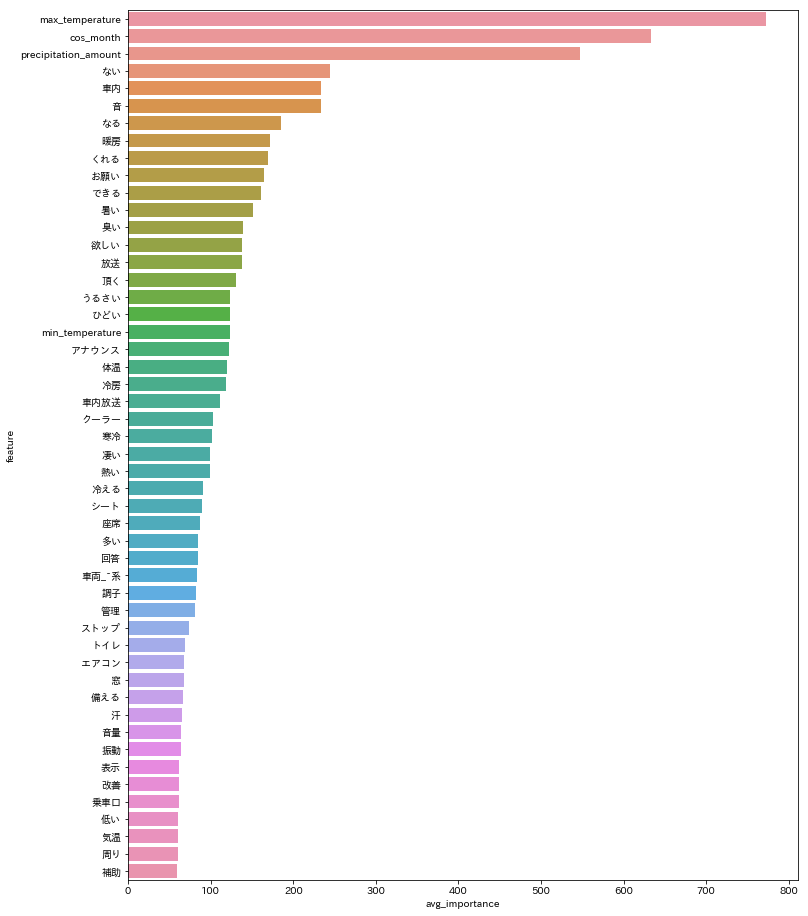

In [84]:
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(12, 16))
sns.barplot(data=LGBM.cv_feim.sort_values(by='avg_importance', ascending=False).iloc[:50, :], x='avg_importance', y='feature')
plt.show()
# viz.set_xticklabels(df_cnt['index'], rotation=90)

## 11.
### 多値分類の結果を出力する
### 予測結果、特徴ワード、特徴ワードの重要度、混同行列元データを結合してTableau用のデータセットを作成
横持ちになっているクラス別の予測確率を縦持ちにした上で、閾値で0/1に変換したカラムを追加作成する→混同行列の元データ

In [49]:
raw_train = pd.read_excel('../input/jr_train2015.xls')[['unique_id', 'date', 'contents', 'target']].dropna()
raw_train2016 = pd.read_excel('../input/jr_train2016.xls')[['unique_id', 'date', 'contents', 'target']].dropna()
raw_test = pd.read_excel('../input/jr_test2017.xls')[['unique_id', 'date', 'contents', 'target']].dropna()
raw_result = pd.concat([raw_train, raw_train2016, raw_test], axis=0).reset_index(drop=True)
raw_result[key] = np.arange(len(raw_result))
raw_result['fiscal_year'] = raw_result['date'].map(lambda x:'2015年度' if int(x.strftime('%Y%m%d')) <20160401 else '2016年度' if int(x.strftime('%Y%m%d')) < 20170401 else '2017年度' )
raw_result.drop(target, axis=1, inplace=True)

# 各テキストについて、分類クラス別の予測確率を縦持ちにする
tmp = result_stack.set_index([key, target, 'prediction']).stack().reset_index().rename(columns={'prediction':'pred_class', 'level_3':'pred_class_detail', 0:'pred_value'}).sort_values(by=[key, 'pred_value'], ascending=False)
tmp = utils.row_number(df=tmp, level=key)
tmp['correct'] = (tmp['target'].values==tmp['pred_class'].values)*1
result = raw_result.merge(tmp, on=key, how='inner')

# 元データから、元テキストをJOINする
result['contents'] = result['contents'].map(lambda x: x.replace('\n', ''))

# ベクトル化を行った入力データから、各テキストが含む単語とその頻度をJOIN
df_all = pd.concat([train, test], axis=0)
viz_cols = [col for col in df_all.columns if not(col.count('max')) and not(col.count('min')) and not(col.count('amount')) and not(col.count('month')) and not(col.count('target'))]
df_all = df_all[viz_cols].stack()
df_word_freq = df_all[df_all>0].reset_index().rename(columns={'level_1':'feature', 0:'freq_in_text'})
result = result.merge(df_word_freq, on=key, how='inner')

# 単語別の重要度をJOINする
result = result.merge(LGBM.cv_feim[['feature', 'avg_importance', 'rank']], on='feature', how='inner').rename(columns={'rank':'feature_rank'})

print(result.shape)

# Save
result.to_csv(f'../output/{start_time[:11]}_jrw_result_pred.csv', index=False)

(675922, 14)


In [261]:
#========================================================================
# Feature Importanceからキーワードを絞り込む
#========================================================================
rank_key = LGBM.cv_feim.copy()
max_feim = rank_key['avg_importance'].max()
rank_key['avg_importance'] = np.round(rank_key['avg_importance'].values / max_feim, 2)
new_feature = list(rank_key[rank_key['rank']<1000]['feature'].values)
len(new_feature)

999

### Ridge

In [243]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
seed = 1208


class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((len(x_train),))
    oof_test = np.zeros((len(x_test),))
    oof_test_skf = np.empty((5, len(test)))

    ' KFold '
    folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)  # 1
    kfold = folds.split(x_train, y)

    for i, (train_index, test_index) in enumerate(kfold):
        x_tr = x_train.iloc[train_index, :].values
        y_tr = y[train_index]
        x_te = x_train.iloc[test_index, :].values

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

sys.exit()
ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':seed}

#Ridge oof method from Faron's kernel
ridge = SklearnWrapper(clf=Ridge, seed = seed, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, train.drop(target, axis=1), y_train, test)
ridge_oof_train

SystemExit: 

In [62]:
from wikipedia2vec import Wikipedia2Vec                                 
MODEL_FILE = '../model/jawiki_20180420_300d.pkl'
wiki2vec = Wikipedia2Vec.load(MODEL_FILE)
ent = "熱"
wiki2vec.get_entity(ent)

<Entity 熱>

In [63]:
wiki2vec.most_similar(wiki2vec.get_entity(ent), 5)

[(<Entity 熱>, 1.0),
 (<Entity 熱源>, 0.59141624),
 (<Entity 燃焼熱>, 0.5894381),
 (<Word 熱>, 0.58162326),
 (<Entity 熱伝達>, 0.580754)]